# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f9fb05e7220>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f9fafc625c0>])

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [9]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
depoly = False

In [11]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [12]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

## 4. Invocation (prediction)

In [13]:
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f9f94600040>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 91.5 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [24]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index


### OpenSearch Client 생성

In [25]:
from utils.opensearch import opensearch_utils

In [26]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [27]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [28]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    rag_fusion=True, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=True, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=False,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True,
)

### QA chain 정의

In [29]:
system_prompt = prompt_repo.get_system_prompt()

In [30]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

홍역 백신 이름
홍역 예방접종 명칭

===== RAG-Fusion Queries =====
['홍역에 대한 백신 이름은?', '홍역 백신 이름', '홍역 예방접종 명칭']

[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

===== ParentDocument =====
filter: [{'bool': {'should': [{'term': {'metadata.family_tree': 'child'}}, {'term': {'metadata.family_tree': 'parent_table'}}, {'term': {'metadata.family_tree': 'parent_image'}}]}}]
# child_docs: 5
# parent docs: 5
# duplicates: 0
##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
True
##############################
HyDE
##############################
False
##############################
parent_document
##############################
True
##############################
complex_document
##############################
True
##########

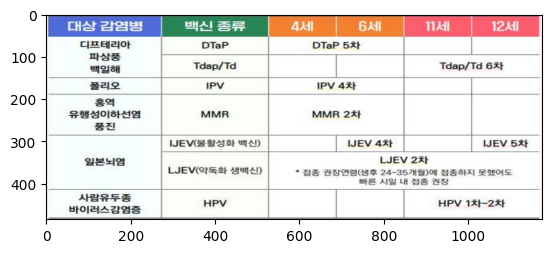

이 이미지는 대상 감염병, 백신 종류, 4세, 6세, 11세, 12세 연령대별로 예방접종 내역을 표시하는 표입니다.
디프테리아, 파상풍, 백일해, 폴리오, 홍역, 유행성이하선염, 임균성병, 사람유두종바이러스감염증 등의 감염병에 대한 백신 종류와 접종 시기가 나와 있습니다. 6세 시기에
Tdap/Td 6차, IPV 4차, MMR 2차, IJEVIJEV 4차, LJEV 2차 등을 접종하도록 되어 있습니다.
metadata:
 {'img_path': './fig/figure-28-56.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'e208944b-cb82-4150-9f08-a17e7c4150bc', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Table, Chunk: 136 Characters
-----------------------------------------------
주요 예방접종 항목과 횟수를 안내하는 표입니다. DTaP, IPV, MMR, IJEV 등의 백신을 4회 또는 2회 접종하고, HPV 백신은 1~2회 접종할 것을 명시하고 있습니다.
마지막 행에는 "청탁금지법 교감 김○식"이라는 내용이 있습니다.


예방접종,횟수
DTaP,4회
IPV,4회
MMR,2회
IJEV(3234 *4^),4회
HPV,1회~2회
---,
## 청탁금지법 교감 김○식,


metadata:
 {'source': './data/complex_pdf/pickle/parsed_llamaparse.md', 'last_modified':
'2024-04-20T12:46:46', 'text_as_html': '<table><tr><td>예방접종</td><td>횟수</td></tr><tr><td>DTaP</td><td
>4회</td></tr><tr><td>IPV</td><td>4회</td></tr><tr><td>MMR</td><td>2회</td></tr><tr><td>IJEV(3234
*4^)</td><td>4회</td></tr><tr><td>HPV</td><td>1회~2회</td></tr><tr><td>---</td><td></td></tr><tr><td>##
청탁금지법 교감 김○식</td><td></td></tr></table>', 'page_number': 10, 'languages': ['kor'], 'parent_id':
'NA', 'filetype': 'text/markdown', 'orig_elements': '', 'file_directory':
'./data/complex_pdf/pickle', 'filename': 'parsed_llamaparse.md', 'category': 'Table',
'origin_table': '예방접종 횟수 DTaP 4회 IPV 4회 MMR 2회 IJEV(3234 *4^) 4회 HPV 1회~2회 --- ## 청탁금지법 교감 김○식',
'family_tree': 'parent_table', 'id': 'b05c5f55-ddfa-488c-98d3-60381d254cd3'}

-----------------------------------------------
3. Category: Table, Chunk: 69 Characters
-----------------------------------------------
표는 감염병 증상과 기저질환 및 장애를 가진 고위험군 학생의 코로나19 백신 접종 

감염병 증상,기저질환 및 장애를 가진 고위험군 학생
코로나19,접종 당일에 대해 출석인정결석처리


metadata:
 {'source': './data/complex_pdf/pickle/parsed_llamaparse.md', 'last_modified':
'2024-04-20T12:46:46', 'text_as_html': '<table><tr><td>감염병 증상</td><td>기저질환 및 장애를 가진 고위험군
학생</td></tr><tr><td>코로나19</td><td>접종 당일에 대해 출석인정결석처리</td></tr></table>', 'page_number': 2,
'languages': ['kor'], 'parent_id': 'NA', 'filetype': 'text/markdown', 'orig_elements': '',
'file_directory': './data/complex_pdf/pickle', 'filename': 'parsed_llamaparse.md', 'category':
'Table', 'origin_table': '감염병 증상 기저질환 및 장애를 가진 고위험군 학생 코로나19 접종 당일에 대해 출석인정결석처리', 'family_tree':
'parent_table', 'id': '26cf8d34-54b5-4989-af18-6fc861554fe7'}

-----------------------------------------------
4. Category: CompositeElement, Chunk: 651 Characters
-----------------------------------------------
교사 나○철 코로나 백신 접종 ▸접종 당일에 대해 출석인정결석처리 ▸이상반응 발생 시 2일까지 출석인정 처리 가능 ▸접종 후 3일부터 질병결석 처리 결석계와 담임교사확인서+증빙서류
(예 방 접 종 확 인 서 ,의 사 소 견 서 등 ) 19 코로나19 학교장 허가교외 체험학습 ▸확진(양성) 시에는 격리 권고 기간 5일 출석 인정 ▸음성 시에는 당일 1일 출석
인정 당 ' 습 + 가 정 습 통 ▸기존 교외체험학습+가정학습 

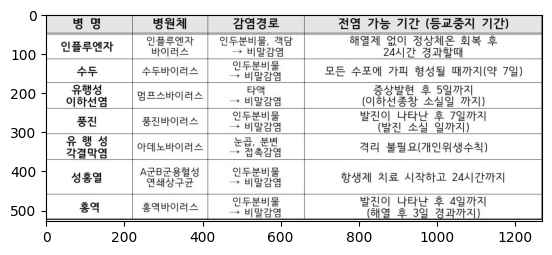

이 표는 여러 가지 전염성 질환에 대한 정보를 제공합니다. 질병 이름, 병원체, 감염경로, 전염 가능 기간, 유행성 등의 내용이 포함되어 있습니다. 인플루엔자, 수두, 유행성
이하선염, 풍진, 유행성 각결막염, 성홍열, 홍역 등의 질병에 대한 데이터를 담고 있습니다.


' 3 따 삐 i,언쓰 ] 따 므 | 736 = oI,뷰 죄 80 통 시 브답 e el od,|19| Sk I | |ou i 꼭 15079 220 | | =< ㅇ eV 122576 sl |
바 바 | <+,긴 오 꼬 바 아,비 4시 과 16 띠 나코,7 일 ) o X 돈 s 0 0 0 =3 |7 = 벗 벗 비
99 |20 700 인 야이 ),07696 | 움 개토 꼬 <| | 비 oo,히 | 피 고 닉,다솜 Wuww)z 춥 고 ;우소 g IR o) Lo |Nloto
_ 0 9,<| e|1Z|g 배 o 꼬 | 0 Ho,2규 ual | 바 꼬 이」닉,Era 드흠 | 아 헤 L= : LT ¢ T 2K sz = 떠 | ㅇ
. 0 oo o3 땐 o,<l 트 키 o 티 기 모,육 e K 30 」팬칫넙 T,T 6어 아 리 =| - 여 여 B 페 띠 ' 핀
보 190 s,": o, 혀곤 : 잔 | 물 좋 B bk",가 o we 바 끄 91,3 : 25 X < 혀 더 브 보 < | = o 료 배 ㅠ 5 | T 100
베 iojo,A_ 옹 | 홈 | g 190,o 1 〕〕_'」티근 비 21,X~ 뺀짜 버럼 뢰 스 _'7 0 에 싸 - ] 레 809 2|


metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'detection_class_prob': 0.9286118149757385,
'coordinates': {'points': [[195.04476928710938, 417.447509765625], [195.04476928710938,
945.0703125], [1465.962890625, 945.0703125], [1465.962890625, 417.447509765625]], 'system':
'PixelSpace', 'layout_width': 1653, 'layout_height': 2337}, 'last_modified': '2024-04-04T01:39:24',
'text_as_html': "<table><thead><th>go| : |</th><th>리 = 해</th><th>때 푸</th><th>= N — — =l o 똥 느 니 S N
== e 벽 &amp;</th></thead><tr><td>' 3 따 삐 i</td><td>언쓰 ] 따 므 | 736 = oI</td><td>뷰 죄 80 통 시 브답 e el
od</td><td>|19| Sk I | |ou i 꼭 15079 220 | | =&lt; ㅇ eV 122576 sl |</td></tr><tr><td>바 바 |
&lt;+</td><td>긴 오 꼬 바 아</td><td>비 4시 과 16 띠 나코</td><td>7 일 ) o X 돈 s 0 0 0 =3 |7 = 벗 벗
비</td></tr><tr><td>99 |20 700 인 야이 )</td><td>07696 | 움 개토 꼬 &lt;| | 비 oo</td><td>히 | 피 고
닉</td><td>다솜 Wuww)z 춥 고 ;우소 g IR o) Lo |Nloto</td></tr><tr><td>_ 0 9</td><td>&lt;| e|1Z|g 배 o 꼬 | 0
Ho</td><td>2규 ual | 바 꼬 이」닉</td><td>Era 드흠 | 아

In [35]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
#query = "자산총계 금액 알려줘"
#query = "대출채권 금액은?"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"

query = "재난 발생 시 대처사항은?"
query = "학교폭력 처리 과정은?"
#query = "감염병의 종류와 경로는?"
query = "홍역에 대한 백신 이름은?"
#query = "MMR 2차의 예방접종 시기는?"
#query = "교육목표는?"
#query = "만기상환금액 알려줘"

response, contexts = qa.invoke(
    query = query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [36]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger = "None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    rag_fusion=False, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=True
)

In [37]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

##
query = "학기 초에 어린이 납치 예방 방법은?" # semantic o, lexical x
query = "차 흡연 옷. 벽면에 붙은 연기로 인한 피해?" # semantic o, lexical x
query = "교육목표는?"
#query = "수익률 그래프 설명해줘"
query = "감염병의 종류와 경로는?"
query = "학교폭력 유형의 개수와 종류 알려줘"
query = "응급처치 방법에 대해서 알려줘"
query = "차 밑에서 물건을 꺼내는 아이는 누가 도와줘야 해?"
query = "공사장 근처에서 노는 아이는 누가 도와줘야 해?"
#query = "중지된 경우 이체"


In [38]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 3


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 3


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

===== ParentDocument =====
filter: [{'bool': {'should': [{'term': {'metadata.family_tree': 'child'}}, {'term': {'metadata.family_tree': 'parent_table'}}, {'term': {'metadata.family_tree': 'parent_image'}}]}}]
# child_docs: 7
# parent docs: 6
# duplicates: 1
##############################
async_mode
##############################
False
##############################
reranker
##############################
True
##############################
rag_fusion
##############################
False
######################

##################################
query:  공사장 근처에서 노는 아이는 누가 도와줘야 해?
##################################


### Answer ###
공사장 근처에서 노는 아이는 위험한 장소이므로 어른의 도움을 받아야 합니다. 정답은 다음과 같이 제시되어 있습니다.

"공사장 옆에서 놀고 있는 아이 ▶ 위험한 장소에서 놀지 않도록 함."

위와 같이 문맥상 위험한 장소인 공사장 근처에서 노는 아이에게는 어른이 개입하여 위험한 장소에서 놀지 않도록 해야 한다고 설명하고 있습니다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 2625 Characters
-----------------------------------------------
19 교육활동 참여자 안전교육(녹색, 폴리스) 교사 이○혜 1.1. 목적목적 어린이들의 통학로 안전성을 확보하고, 안전하게 등하교 할 수 있도록 도와주며, 아동 대상 범죄 및 학
교 주변에서 자주 발생하는 학교폭력과 유해환경에서 어린이들을 안전하게 보호하기 위함임. 2. 다양한 발생 사례 2. 다양한 발생 사례 가. 스쿨존 내 학생 교통사고 사례 :
아이들은 잘 뛰어다녀요 r\/\QU CICRONCORES . 교 ① 무단횡단을 하는 어른을 보고 따라하는 경우 ② 초록불이 들어오자마자 갑자기 뛰어드는 경우 ③ 인도가 없는
이면도로를 지다가는 경우 ④ 횡단보도 앞에 주‧정차된 차 앞을 지나가는 경우 ⑤ 통학버스 또는 부모님 차량에서 내려 급하게 횡단보도를 건너가는 경우 보 요 . 아 험 례 : 고 는
나. 학교 교육활동 중 위험 사례 : 아이들은 몸집이 작아 잘 안보여요 ① 차도로 굴러가는 공을 쫒아가는 아이 ▶ 어른의 도움을 받도록 함. ② 차 밑에서 공(물건)을 빼고 있는
아이 ▶ 어른의 도움을 받도록 함. ③ 차 뒤에서

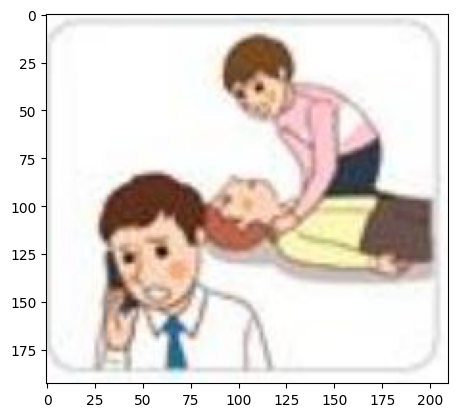

이 이미지는 남자 아이와 여자 아이 두 명이 나오는 그림입니다. 남자 아이는 책상에 엎드려 있고, 여자 아이는 그의 등을 토닥이며 위로하는 모습을 담고 있습니다. 아이들의 표정과
행동을 통해 따뜻한 우정과 배려심 있는 모습을 보여주고 있습니다.
metadata:
 {'img_path': './fig/table-2-resize.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '3ac74f5e-85f1-44e7-9d8b-74d4848f0c59', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
6. Category: Image, Chunk: 169 Characters
-----------------------------------------------


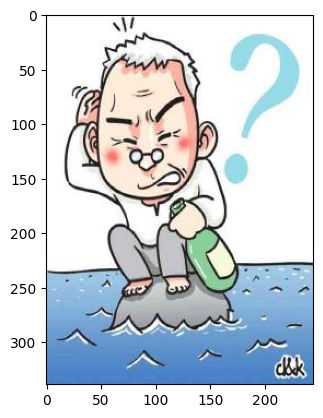

이미지는 물에 빠진 작은 남자 아이의 표정을 묘사한 그림입니다. 아이는 화가 나고 혼란스러운 표정을 짓고 있으며, 물에 반쯤 잠겨 있습니다. 이런 상황은 아마도 아이가 실수로 물에
빠졌거나 장난치다가 빠진 것으로 보입니다. 그림은 유머러스한 터치로 아이의 당황스러운 모습을 재치 있게 표현하고 있습니다.
metadata:
 {'img_path': './fig/figure-29-60.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'b8c0f256-a775-4aea-bf2e-bd50d577650b', 'origin_image': '',
'orig_elements': ''}


In [39]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)